In [1]:
#Import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

import pickle

# Radomization tests


In this notebook we going show a randomization test using CIFAR10 dataset, the idea is to compare the accuracy of a model with the accuracy of a model with the same architecture but with the labels corrupted, to corrupt the labels we will use a random selection from the CIFAR10 labels. The CIFAR10 dataset has 10 classes, there are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck. To execute the random choice is used a probability that indicates the probability of the label be changed- The randomization breaks any relationship between the instance, for example, the image, and the label. We then run the learning algorithm both on the natural data and on the randomized data with identical settings and model choice.(pag 107)


## Corruption of the labels with a percentage

In [37]:
"""
La clase CIFAR10Corrupted es una subclase de CIFAR10 que permite corromper las etiquetas de las imágenes con una probabilidad dada.
"""
class CIFAR10Corrupted(CIFAR10):
    def __init__(self, corrupt_prob, num_classes=10, **kwargs):
        super().__init__(**kwargs)
        if corrupt_prob > 0:
            self.n_classes = num_classes
            self.corrupt_labels(corrupt_prob)

    def corrupt_labels(self, corrupt_prob):
        """
        Dada una probabilidad corrupt_prob, se corrompen las etiquetas de las imágenes con dicha probabilidad.
        """
        labels = np.array(self.targets)
        np.random.seed(42)
        mask = np.random.rand(len(labels)) <= corrupt_prob
        rnd_labels = np.random.choice(self.n_classes, mask.sum())
        labels[mask] = rnd_labels
        labels = [int(x) for x in labels]
        self.targets = labels

To see the effect of the corruption of the labels we will show a batch of images with corrupted using the class `CIFAR10Corrupted` that is a subclass of `torchvision.datasets.CIFAR10` that corrupts the labels with a probability `corruption_prob`.


Files already downloaded and verified


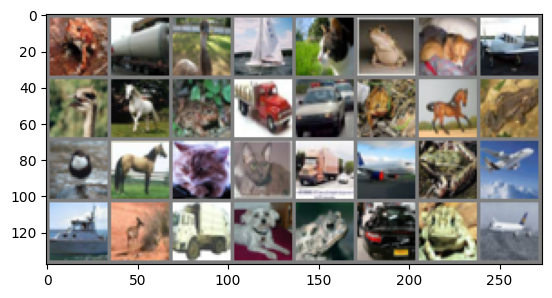

Etiquetas: 
 airplane
 airplane
 horse
 airplane
   dog
  frog
   dog
  deer
  bird
  deer
  frog
 truck
 automobile
  frog
 horse
  frog
  bird
  frog
 horse
   cat
   cat
 airplane
  frog
  bird
 airplane
  deer
   cat
   dog
  frog
  deer
  frog
 airplane



In [42]:
def imshow(img):
    img = img / 2 + 0.5  # Desnormalizar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

corrupt_prob = 0.5 # Probabilidad de corrupción
batch_size = 32  # Tamaño del lote

# Transformaciones
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Crear el conjunto de datos CIFAR10Corrupted
trainset = CIFAR10Corrupted(root='./CIFAR', train=True, download=True, transform=transform, corrupt_prob=corrupt_prob)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

# Obtener un lote de imágenes
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Mostrar las imágenes
imshow(torchvision.utils.make_grid(images))
name_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print('Etiquetas: \n', ' '.join('%5s\n' % name_labels[labels[j]] for j in range(batch_size)))


In [18]:
"""
Esta función devuelve los dataloaders de CIFAR10 con las imágenes corrompidas con una probabilidad dada.
Los dataloaders son los mismos que los de CIFAR10, pero con las etiquetas corrompidas, estos se encargan de cargar los datos en lotes.
"""
def get_cifar_dataloaders_corrupted(corrupt_prob=0, batch_size=32):
    transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    trainset = CIFAR10Corrupted(root='./CIFAR', train=True, download=True, transform=transform, corrupt_prob=corrupt_prob)
    print("Trainset: ", trainset)
    train_loader = DataLoader(trainset, batch_size = batch_size, shuffle = True)
    testset = CIFAR10Corrupted(root='./CIFAR', train=False, download=True, transform=transform, corrupt_prob=corrupt_prob)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader



In [4]:
class ConvModule(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvModule, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x
 
class InceptionModule(nn.Module):
    
    def __init__(self, in_channels, f_1x1, f_3x3):
        super(InceptionModule, self).__init__()
        
        self.branch1 = nn.Sequential(
            ConvModule(in_channels, f_1x1, kernel_size=1, stride=1, padding=0)
        )
        
        self.branch2 = nn.Sequential(
            ConvModule(in_channels, f_3x3, kernel_size=3, stride=1, padding=1)
        )
                
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        return torch.cat([branch1, branch2], 1)


class DownsampleModule(nn.Module):
    def __init__(self, in_channels, f_3x3):
        super(DownsampleModule, self).__init__()
    
        self.branch1 = nn.Sequential(ConvModule(in_channels, f_3x3, kernel_size=3, stride=2, padding=0))
        self.branch2 = nn.MaxPool2d(3, stride=2)
    
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        return torch.cat([branch1, branch2], 1)
   
class InceptionNet(nn.Module):
    def __init__(self, num_classes = 10):
        super().__init__()
        
        self.conv1 = ConvModule(in_channels =3,out_channels=96, kernel_size=3, stride=1, padding=0)
        self.inception1 = InceptionModule(in_channels=96,f_1x1=32,f_3x3=32)
        self.inception2 = InceptionModule(in_channels=64,f_1x1=32,f_3x3=48)
        self.down1 = DownsampleModule(in_channels=80,f_3x3=80)
        self.inception3 = InceptionModule(in_channels=160,f_1x1=112,f_3x3=48)
        self.inception4 = InceptionModule(in_channels=160,f_1x1=96,f_3x3=64)
        self.inception5 = InceptionModule(in_channels=160,f_1x1=80,f_3x3=80)
        self.inception6 = InceptionModule(in_channels=160,f_1x1=48,f_3x3=96)   
        self.down2 = DownsampleModule(in_channels=144,f_3x3=96)
        self.inception7 = InceptionModule(in_channels=240,f_1x1=176,f_3x3=160)
        self.inception8 = InceptionModule(in_channels=336,f_1x1=176,f_3x3=160)
        self.meanpool = nn.AdaptiveAvgPool2d((7,7))
        self.fc = nn.Linear(16464, num_classes)
       
    def forward(self, x):
        x = self.conv1(x)
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.down1(x)
        x = self.inception3(x)
        x = self.inception4(x)
        x = self.inception5(x)
        x = self.inception6(x)
        x = self.down2(x)
        x = self.inception7(x)
        x = self.inception8(x)
        x = self.meanpool(x)
        x = torch.flatten(x,1)
        x = self.fc(x)
        return x

In [5]:
def run_train_single_epoch(train_loader, model, device, criterion, optimizer):
    running_loss = 0.0
    num_correct = 0
    for batch_num, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()*len(inputs)
        if batch_num%200==0:
            print("Batch {} Loss: {}".format(batch_num, loss.item()))
        preds = outputs.argmax(1)
        num_correct += (preds==labels).sum().item()
    epoch_loss = running_loss/len(train_loader.sampler)
    epoch_acc = num_correct/len(train_loader.sampler)
    return epoch_loss, epoch_acc

def run_validation_single_epoch(valid_loader, model, device, criterion):
    running_loss = 0.0
    num_correct = 0
    for batch_num, data in enumerate(valid_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()*len(inputs)
        preds = outputs.argmax(1)
        num_correct += (preds==labels).sum().item()
    epoch_loss = running_loss/len(valid_loader.sampler)
    epoch_acc = num_correct/len(valid_loader.sampler)
    return epoch_loss, epoch_acc

def training_loop(model, num_epochs, train_loader, valid_loader, device, \
                  criterion, optimizer, model_name):
    train_losses, valid_losses = [], []
    train_accs, valid_accs = [], []
    highest_acc = 1e-10
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_acc = run_train_single_epoch(train_loader, model, device, criterion, optimizer)
        model.eval()
        valid_loss, valid_acc = run_validation_single_epoch(valid_loader, model, device, criterion)
        print("[Epoch {}] Train Loss: {} Vaidation Loss: {} Train Acc: {} Validation Acc: {}".format(\
              epoch, train_loss, valid_loss, train_acc, valid_acc))
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accs.append(train_acc)
        valid_accs.append(valid_acc)
        if valid_acc > highest_acc:
            torch.save(model.state_dict(), "{}.pth".format(model_name))
            highest_acc = valid_acc
        # else:
        #     print("Early stopping.")
        #     break
    print('Finished Training')
    return train_losses, valid_losses, train_accs, valid_accs

def run_testing(test_loader, model, device):
    model.eval()
    gt_all, preds_all = [], []
    for batch_num, data in enumerate(test_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(1)
        gt_all.extend(labels.tolist())
        preds_all.extend(preds.tolist())
    return gt_all, preds_all
    

In [6]:
def plot_losses(training_loss_arr, validation_loss_arr, training_acc_arr, validation_acc_arr, \
                title):
    num_epochs = len(training_loss_arr)
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    ax = plt.gca()
    ax.plot(range(num_epochs), training_loss_arr, '-bo', label="Training Loss")
    ax.plot(range(num_epochs), validation_loss_arr, '-ro', label="Validation Loss")
    ax.legend()
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.set_title(title)
    plt.subplot(1,2,2)
    ax = plt.gca()
    ax.plot(range(num_epochs), training_acc_arr, '-bo', label="Training Acc")
    ax.plot(range(num_epochs), validation_acc_arr, '-ro', label="Validation Acc")
    ax.legend()
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.set_title(title)    

In [7]:
final_dict = dict()

# Test for corruption level 0.0

In [8]:
train_loader, test_loader = get_cifar_dataloaders_corrupted(0)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


100.0%


Extracting ./CIFAR/cifar-10-python.tar.gz to ./CIFAR
Files already downloaded and verified
cuda:0


In [9]:
model = InceptionNet()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)


In [10]:
train_losses, valid_losses, train_accs, validation_accs = training_loop(model, 10, train_loader, test_loader,
                                          device, criterion, optimizer, "InceptionNet_corr_0")

Batch 0 Loss: 2.4048032760620117
Batch 200 Loss: 1.5209490060806274
Batch 400 Loss: 1.5448708534240723
Batch 600 Loss: 1.4097254276275635
Batch 800 Loss: 1.3211420774459839
Batch 1000 Loss: 1.4609973430633545
Batch 1200 Loss: 0.6678557395935059
Batch 1400 Loss: 0.6911308169364929
[Epoch 0] Train Loss: 1.2362448168754578 Vaidation Loss: 0.8951348472595215 Train Acc: 0.57996 Validation Acc: 0.7004
Batch 0 Loss: 0.7921503782272339
Batch 200 Loss: 0.6382713317871094
Batch 400 Loss: 0.6382245421409607
Batch 600 Loss: 0.4776500463485718
Batch 800 Loss: 0.6618199944496155
Batch 1000 Loss: 0.7478490471839905
Batch 1200 Loss: 0.8732336759567261
Batch 1400 Loss: 0.5842816829681396
[Epoch 1] Train Loss: 0.7397478844165802 Vaidation Loss: 0.705172193145752 Train Acc: 0.7482 Validation Acc: 0.7621
Batch 0 Loss: 0.7742465734481812
Batch 200 Loss: 0.46860286593437195
Batch 400 Loss: 0.3659501075744629
Batch 600 Loss: 0.5033878684043884
Batch 800 Loss: 0.17931808531284332
Batch 1000 Loss: 0.2712250351

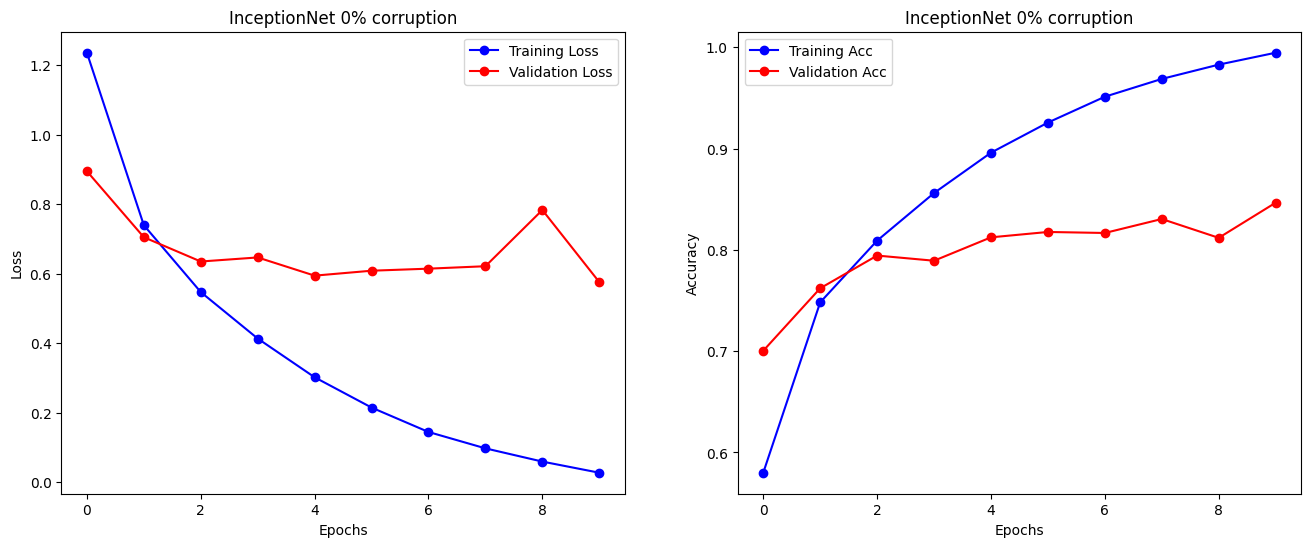

In [11]:
plot_losses(train_losses, valid_losses, train_accs, validation_accs, "InceptionNet 0% corruption")

In [12]:
model = InceptionNet()
sd = torch.load("InceptionNet_corr_0.pth")
model.load_state_dict(sd)
model = model.to(device)
testy, pred = run_testing(test_loader, model, device)

print("Accuracy:", accuracy_score(testy, pred))
print("Confusion Matrix:\n", confusion_matrix(testy, pred))


Accuracy: 0.837
Confusion Matrix:
 [[881  15  14   8   5   5   5   6  35  26]
 [  7 950   0   1   2   3   0   2   8  27]
 [ 74   2 717  49  53  31  48  13   6   7]
 [ 20  13  41 699  44  97  38  27  13   8]
 [ 23   1  33  43 823   8  23  39   6   1]
 [ 15   6  22 127  29 749  12  38   1   1]
 [  8   6  14  46  14  10 880  11   9   2]
 [ 16   1  13  24  28  27   1 879   5   6]
 [ 45  20   2   7   1   2   1   3 909  10]
 [ 24  60   1   5   0   1   4   2  20 883]]


In [13]:
final_dict[0] = {}
final_dict[0]["train_losses"] = train_losses
final_dict[0]["valid_losses"] = valid_losses
final_dict[0]["train_accs"] = train_accs
final_dict[0]["validation_accs"] = validation_accs
final_dict[0]["best_test_acc"] = accuracy_score(testy, pred)


In [14]:
train_loader, test_loader = get_cifar_dataloaders_corrupted(0.2)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


Files already downloaded and verified
Files already downloaded and verified
cuda:0


In [15]:
model = InceptionNet()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)


In [16]:
train_losses, valid_losses, train_accs, validation_accs = training_loop(model, 10, train_loader, test_loader,
                                          device, criterion, optimizer, "InceptionNet_corr_20")

Batch 0 Loss: 2.3671553134918213
Batch 200 Loss: 2.468792676925659
Batch 400 Loss: 1.9719972610473633
Batch 600 Loss: 1.9756159782409668
Batch 800 Loss: 1.5178799629211426
Batch 1000 Loss: 1.106667160987854
Batch 1200 Loss: 1.5584248304367065
Batch 1400 Loss: 1.64621901512146
[Epoch 0] Train Loss: 1.8375717015457154 Vaidation Loss: 1.566264579963684 Train Acc: 0.42756 Validation Acc: 0.5343
Batch 0 Loss: 1.7152074575424194
Batch 200 Loss: 1.5192862749099731
Batch 400 Loss: 1.1609277725219727
Batch 600 Loss: 1.205207347869873
Batch 800 Loss: 0.9884896874427795
Batch 1000 Loss: 1.3900974988937378
Batch 1200 Loss: 1.318469762802124
Batch 1400 Loss: 1.070607304573059
[Epoch 1] Train Loss: 1.4814714067840575 Vaidation Loss: 1.5075380741119384 Train Acc: 0.56422 Validation Acc: 0.5755
Batch 0 Loss: 1.2056312561035156
Batch 200 Loss: 1.498072862625122
Batch 400 Loss: 1.5052790641784668
Batch 600 Loss: 1.0829542875289917
Batch 800 Loss: 1.3386074304580688
Batch 1000 Loss: 1.3388856649398804
Ba

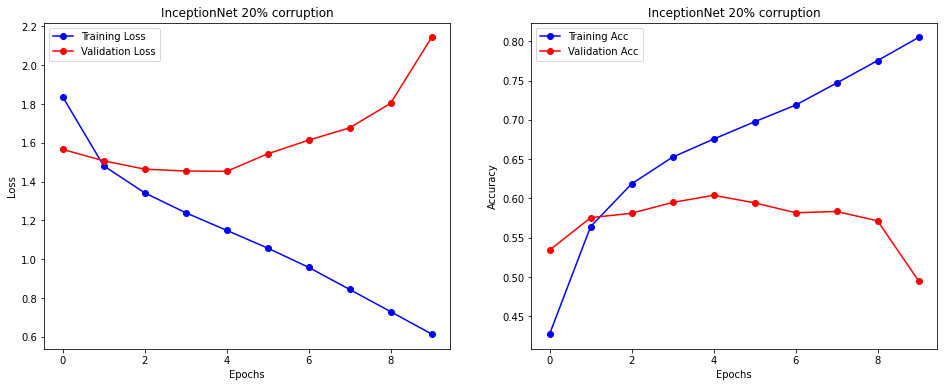

In [17]:
plot_losses(train_losses, valid_losses, train_accs, validation_accs, "InceptionNet 20% corruption")

In [18]:
model = InceptionNet()
sd = torch.load("InceptionNet_corr_20.pth")
model.load_state_dict(sd)
model = model.to(device)
testy, pred = run_testing(test_loader, model, device)

print("Accuracy:", accuracy_score(testy, pred))
print("Confusion Matrix:\n", confusion_matrix(testy, pred))


Accuracy: 0.604
Confusion Matrix:
 [[702  23  62  43  32  25  18  25  54  12]
 [ 51 687  39  35  23  24  22  19  72  28]
 [100  32 579  72  72  32  33  24  25  20]
 [ 66  33  95 561  70  98  27  26  39  18]
 [ 49  23 111  78 606  19  19  35  28  18]
 [ 48  27 109 184  63 463  28  41  15  12]
 [ 34  22 145  98  55  37 553  22  39  13]
 [ 72  26  73  68  68  52  11 565  26  10]
 [ 91  21  45  40  15  20  12  17 714  22]
 [ 65  92  41  55  30  25  18  20  64 610]]


In [19]:
final_dict[20] = {}
final_dict[20]["train_losses"] = train_losses
final_dict[20]["valid_losses"] = valid_losses
final_dict[20]["train_accs"] = train_accs
final_dict[20]["validation_accs"] = validation_accs
final_dict[20]["best_test_acc"]  = accuracy_score(testy, pred)


In [20]:
train_loader, test_loader = get_cifar_dataloaders_corrupted(0.4)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


Files already downloaded and verified
Files already downloaded and verified
cuda:0


In [21]:
model = InceptionNet()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)


In [22]:
train_losses, valid_losses, train_accs, validation_accs = training_loop(model, 10, train_loader, test_loader,
                                          device, criterion, optimizer, "InceptionNet_corr_40")

Batch 0 Loss: 2.33540940284729
Batch 200 Loss: 2.366856813430786
Batch 400 Loss: 2.2762489318847656
Batch 600 Loss: 2.1831188201904297
Batch 800 Loss: 2.094660997390747
Batch 1000 Loss: 1.9997894763946533
Batch 1200 Loss: 2.2224602699279785
Batch 1400 Loss: 1.9131624698638916
[Epoch 0] Train Loss: 2.1553488302993773 Vaidation Loss: 1.9867485404968261 Train Acc: 0.29446 Validation Acc: 0.358
Batch 0 Loss: 1.6547127962112427
Batch 200 Loss: 1.8774195909500122
Batch 400 Loss: 1.7562668323516846
Batch 600 Loss: 1.868841290473938
Batch 800 Loss: 1.8756873607635498
Batch 1000 Loss: 1.9662165641784668
Batch 1200 Loss: 2.096069097518921
Batch 1400 Loss: 2.1361277103424072
[Epoch 1] Train Loss: 1.906460111618042 Vaidation Loss: 1.909598090362549 Train Acc: 0.39944 Validation Acc: 0.4102
Batch 0 Loss: 2.033663511276245
Batch 200 Loss: 1.6684221029281616
Batch 400 Loss: 1.9519033432006836
Batch 600 Loss: 1.7519795894622803
Batch 800 Loss: 1.7758368253707886
Batch 1000 Loss: 1.9594786167144775
Bat

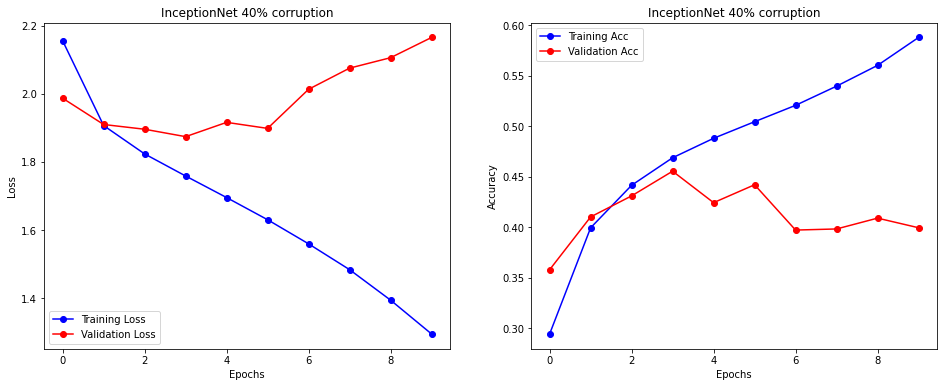

In [23]:
plot_losses(train_losses, valid_losses, train_accs, validation_accs, "InceptionNet 40% corruption")

In [24]:
model = InceptionNet()
sd = torch.load("InceptionNet_corr_40.pth")
model.load_state_dict(sd)
model = model.to(device)
testy, pred = run_testing(test_loader, model, device)

print("Accuracy:", accuracy_score(testy, pred))
print("Confusion Matrix:\n", confusion_matrix(testy, pred))


Accuracy: 0.4554
Confusion Matrix:
 [[558  55  36  52  64  47  49  37  76  46]
 [ 66 567  32  48  60  36  48  31  70  51]
 [127  49 305  68 119 103  76  53  62  32]
 [ 84  56  47 371 135 137  57  51  49  46]
 [ 72  45  64  55 494  55  74  53  51  28]
 [ 74  43  57 132 106 376  58  54  51  30]
 [ 57  35  46  81  90  55 532  41  45  30]
 [ 66  39  39  57 121  99  45 401  54  64]
 [129  58  32  38  47  31  47  47 511  31]
 [ 90 105  28  57  66  53  45  42  79 439]]


In [25]:
final_dict[40] = {}
final_dict[40]["train_losses"] = train_losses
final_dict[40]["valid_losses"] = valid_losses
final_dict[40]["train_accs"] = train_accs
final_dict[40]["validation_accs"] = validation_accs
final_dict[40]["best_test_acc"]  = accuracy_score(testy, pred)


In [26]:
train_loader, test_loader = get_cifar_dataloaders_corrupted(0.6)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


Files already downloaded and verified
Files already downloaded and verified
cuda:0


In [27]:
model = InceptionNet()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)


In [28]:
train_losses, valid_losses, train_accs, validation_accs = training_loop(model, 10, train_loader, test_loader,
                                          device, criterion, optimizer, "InceptionNet_corr_60")

Batch 0 Loss: 2.4087162017822266
Batch 200 Loss: 2.6759228706359863
Batch 400 Loss: 2.533828020095825
Batch 600 Loss: 2.014007329940796
Batch 800 Loss: 2.175114154815674
Batch 1000 Loss: 2.3232498168945312
Batch 1200 Loss: 2.342381000518799
Batch 1400 Loss: 2.1284689903259277
[Epoch 0] Train Loss: 2.3135684673690795 Vaidation Loss: 2.1693429538726807 Train Acc: 0.19918 Validation Acc: 0.2551
Batch 0 Loss: 2.080568790435791
Batch 200 Loss: 1.9697701930999756
Batch 400 Loss: 2.2656683921813965
Batch 600 Loss: 2.2422547340393066
Batch 800 Loss: 2.288656234741211
Batch 1000 Loss: 2.3013217449188232
Batch 1200 Loss: 2.0951087474823
Batch 1400 Loss: 2.136146306991577
[Epoch 1] Train Loss: 2.1581936528778076 Vaidation Loss: 2.1815813167572022 Train Acc: 0.26766 Validation Acc: 0.2686
Batch 0 Loss: 2.082149028778076
Batch 200 Loss: 2.157132148742676
Batch 400 Loss: 2.201970338821411
Batch 600 Loss: 2.1510040760040283
Batch 800 Loss: 2.332545757293701
Batch 1000 Loss: 2.016505002975464
Batch 12

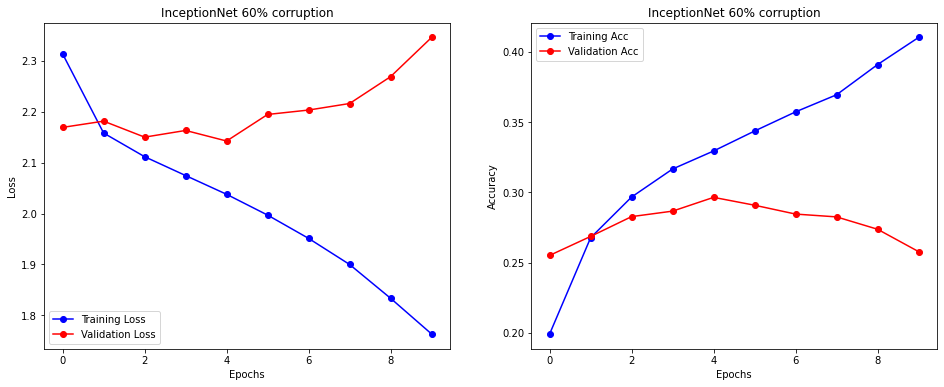

In [29]:
plot_losses(train_losses, valid_losses, train_accs, validation_accs, "InceptionNet 60% corruption")

In [30]:
model = InceptionNet()
sd = torch.load("InceptionNet_corr_60.pth")
model.load_state_dict(sd)
model = model.to(device)
testy, pred = run_testing(test_loader, model, device)

print("Accuracy:", accuracy_score(testy, pred))
print("Confusion Matrix:\n", confusion_matrix(testy, pred))


Accuracy: 0.2964
Confusion Matrix:
 [[304  60 143  65  36  63  79  99  55 123]
 [ 52 344  93  65  35  72  81  84  55 145]
 [ 74  52 283  84  41  87  99 106  62  98]
 [ 53  54 120 213  40 154 124 105  56 102]
 [ 64  51 132  83 150  99 112 149  57  82]
 [ 47  57 111 101  29 277  86 103  66  97]
 [ 65  56  94  72  36  79 387  85  47  91]
 [ 67  65 112  75  39  99  82 341  41  88]
 [ 81  88  65  67  24  73  67  83 296 136]
 [ 47  86  90  63  31  63  86  88  63 369]]


In [31]:
final_dict[60] = {}
final_dict[60]["train_losses"] = train_losses
final_dict[60]["valid_losses"] = valid_losses
final_dict[60]["train_accs"] = train_accs
final_dict[60]["validation_accs"] = validation_accs
final_dict[60]["best_test_acc"]  = accuracy_score(testy, pred)


In [32]:
train_loader, test_loader = get_cifar_dataloaders_corrupted(0.8)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


Files already downloaded and verified
Files already downloaded and verified
cuda:0


In [33]:
model = InceptionNet()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)


In [34]:
train_losses, valid_losses, train_accs, validation_accs = training_loop(model, 10, train_loader, test_loader,
                                          device, criterion, optimizer, "InceptionNet_corr_80")

Batch 0 Loss: 2.220757484436035
Batch 200 Loss: 3.0906989574432373
Batch 400 Loss: 2.487333059310913
Batch 600 Loss: 2.508023738861084
Batch 800 Loss: 2.3235533237457275
Batch 1000 Loss: 2.2725746631622314
Batch 1200 Loss: 2.333346366882324
Batch 1400 Loss: 2.3196938037872314
[Epoch 0] Train Loss: 2.434643977432251 Vaidation Loss: 2.295670069885254 Train Acc: 0.1245 Validation Acc: 0.1489
Batch 0 Loss: 2.3724188804626465
Batch 200 Loss: 2.224088430404663
Batch 400 Loss: 2.303980588912964
Batch 600 Loss: 2.2898106575012207
Batch 800 Loss: 2.237786054611206
Batch 1000 Loss: 2.4236204624176025
Batch 1200 Loss: 2.3619236946105957
Batch 1400 Loss: 2.238661289215088
[Epoch 1] Train Loss: 2.288613004989624 Vaidation Loss: 2.2943020389556885 Train Acc: 0.15574 Validation Acc: 0.1464
Batch 0 Loss: 2.2904465198516846
Batch 200 Loss: 2.2765893936157227
Batch 400 Loss: 2.2924020290374756
Batch 600 Loss: 2.332824230194092
Batch 800 Loss: 2.1654019355773926
Batch 1000 Loss: 2.2135636806488037
Batch 

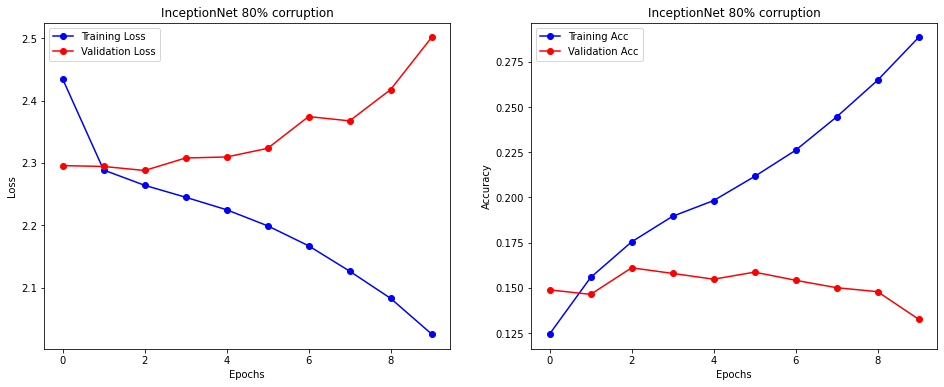

In [35]:
plot_losses(train_losses, valid_losses, train_accs, validation_accs, "InceptionNet 80% corruption")

In [36]:
model = InceptionNet()
sd = torch.load("InceptionNet_corr_80.pth")
model.load_state_dict(sd)
model = model.to(device)
testy, pred = run_testing(test_loader, model, device)

print("Accuracy:", accuracy_score(testy, pred))
print("Confusion Matrix:\n", confusion_matrix(testy, pred))


Accuracy: 0.1611
Confusion Matrix:
 [[ 57 170 214  37   4  48 165 206  71  39]
 [ 23 292 141  28   2  46 184 204  54  55]
 [ 22 128 236  46   3  58 201 208  47  38]
 [ 21 162 182  45   5  73 224 211  40  57]
 [ 18 122 231  35  14  57 207 186  44  40]
 [ 25 141 193  54   7  96 192 181  47  45]
 [ 17 122 168  31   9  43 341 166  67  51]
 [ 22 143 165  25   6  66 170 293  57  51]
 [ 25 173 179  30   1  42 194 171 119  53]
 [ 27 219 149  37   4  47 177 186  54 118]]


In [37]:
final_dict[80] = {}
final_dict[80]["train_losses"] = train_losses
final_dict[80]["valid_losses"] = valid_losses
final_dict[80]["train_accs"] = train_accs
final_dict[80]["validation_accs"] = validation_accs
final_dict[80]["best_test_acc"]  = accuracy_score(testy, pred)


In [38]:
train_loader, test_loader = get_cifar_dataloaders_corrupted(1.0)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


Files already downloaded and verified
Files already downloaded and verified
cuda:0


In [39]:
model = InceptionNet()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)


In [40]:
train_losses, valid_losses, train_accs, validation_accs = training_loop(model, 10, train_loader, test_loader,
                                          device, criterion, optimizer, "InceptionNet_corr_100")

Batch 0 Loss: 2.2835397720336914
Batch 200 Loss: 2.745244026184082
Batch 400 Loss: 2.642238140106201
Batch 600 Loss: 2.3055098056793213
Batch 800 Loss: 2.3714346885681152
Batch 1000 Loss: 2.371880292892456
Batch 1200 Loss: 2.3487892150878906
Batch 1400 Loss: 2.32818341255188
[Epoch 0] Train Loss: 2.4093898625183106 Vaidation Loss: 2.3538221725463866 Train Acc: 0.10094 Validation Acc: 0.1026
Batch 0 Loss: 2.3010332584381104
Batch 200 Loss: 2.2876574993133545
Batch 400 Loss: 2.2809300422668457
Batch 600 Loss: 2.2345428466796875
Batch 800 Loss: 2.2927606105804443
Batch 1000 Loss: 2.4008984565734863
Batch 1200 Loss: 2.345268487930298
Batch 1400 Loss: 2.30667781829834
[Epoch 1] Train Loss: 2.316379468307495 Vaidation Loss: 2.3133903553009034 Train Acc: 0.10438 Validation Acc: 0.1015
Batch 0 Loss: 2.2651798725128174
Batch 200 Loss: 2.3130764961242676
Batch 400 Loss: 2.3018980026245117
Batch 600 Loss: 2.3049654960632324
Batch 800 Loss: 2.3605048656463623
Batch 1000 Loss: 2.240093231201172
Bat

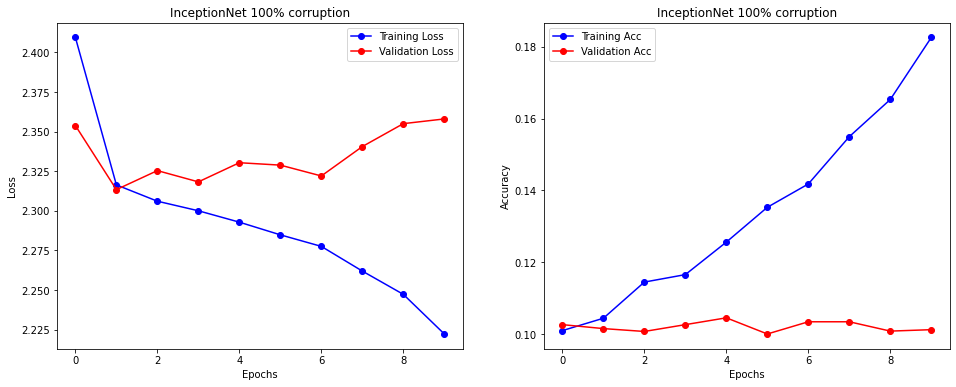

In [41]:
plot_losses(train_losses, valid_losses, train_accs, validation_accs, "InceptionNet 100% corruption")

In [42]:
model = InceptionNet()
sd = torch.load("InceptionNet_corr_100.pth")
model.load_state_dict(sd)
model = model.to(device)
testy, pred = run_testing(test_loader, model, device)

print("Accuracy:", accuracy_score(testy, pred))
print("Confusion Matrix:\n", confusion_matrix(testy, pred))


Accuracy: 0.1045
Confusion Matrix:
 [[ 10 100   1  36   6 599   4 252   3   3]
 [  5 125   2  29   5 577   5 286   1   5]
 [  4  91   2  43   7 564   5 267   0   8]
 [  6 102   3  36  10 581   3 266   2   3]
 [  7  87   3  26   8 531   5 274   1   3]
 [  6 110   5  31   0 586   4 265   5   5]
 [  2 123   1  40   4 571   3 247   1   5]
 [  3  94   2  32   6 575   5 271   0   5]
 [  5  84   1  34   4 596   1 242   2   4]
 [  3  93   3  37   7 622   7 242   2   2]]


In [43]:
final_dict[100] = {}
final_dict[100]["train_losses"] = train_losses
final_dict[100]["valid_losses"] = valid_losses
final_dict[100]["train_accs"] = train_accs
final_dict[100]["validation_accs"] = validation_accs
final_dict[100]["best_test_acc"]  = accuracy_score(testy, pred)


In [44]:
with open('final.pickle', 'wb') as f:
    pickle.dump(final_dict, f, protocol=pickle.HIGHEST_PROTOCOL)


In [45]:
!curl bashupload.com -T final.pickle

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Uploaded 1 file, 2 634 bytes

wget http://bashupload.com/UkA_M/final.pickle


100  2766    0   132  100  2634    463   9242 --:--:-- --:--:-- --:--:--  9705


In [46]:
!zip inception.zip *.*
!curl bashupload.com -T inception.zip

  adding: final.pickle (deflated 18%)
  adding: InceptionNet_corr_0.pth (deflated 8%)
  adding: InceptionNet_corr_100.pth (deflated 8%)
  adding: InceptionNet_corr_20.pth (deflated 8%)
  adding: InceptionNet_corr_40.pth (deflated 8%)
  adding: InceptionNet_corr_60.pth (deflated 8%)
  adding: InceptionNet_corr_80.pth (deflated 8%)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 62 38.3M    0     0   62 23.8M      0  14.9M  0:00:02  0:00:01  0:00:01 14.9M

Uploaded 1 file, 40 242 041 bytes

wget http://bashupload.com/8wuKp/inception.zip


100 38.3M    0   138  100 38.3M     46  12.8M  0:00:02  0:00:02 --:--:-- 12.8M
